In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2025-07-16 16:26:24.977723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 16:26:25.318861: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Sampling datasets

In [2]:
def create_mix_sample_from(npy_dirs: list, nevents: tuple, ratios=(0.8, 0.2), seed=0):
    # npy_dirs: list of npy directories
    # nevents: tuple of (n_VBF_SR, n_VBF_BR, n_GGF_SR, n_GGF_BR)
    # ratios: tuple of (r_train, r_val)
    data_tr, data_vl, data_te = None, None, None
    label_tr, label_vl, label_te = None, None, None

    npy_dir0 = Path(npy_dirs[0])

    data_VBF_SR = np.load(npy_dir0 / 'VBF_in_SR-data.npy')
    data_VBF_BR = np.load(npy_dir0 / 'VBF_in_BR-data.npy')
    data_GGF_SR = np.load(npy_dir0 / 'GGF_in_SR-data.npy')
    data_GGF_BR = np.load(npy_dir0 / 'GGF_in_BR-data.npy')

    n_VBF_SR, n_GGF_SR, n_VBF_BR, n_GGF_BR = nevents
    n_test = 10000
    n_VBF_SR_test = int(data_VBF_SR.shape[0] / (data_VBF_SR.shape[0] + data_VBF_BR.shape[0]) * n_test)
    n_VBF_BR_test = n_test - n_VBF_SR_test
    n_GGF_SR_test = int(data_GGF_SR.shape[0] / (data_GGF_SR.shape[0] + data_GGF_BR.shape[0]) * n_test)
    n_GGF_BR_test = n_test - n_GGF_SR_test

    r_tr, r_vl = ratios

    np.random.seed(seed)
    print(data_GGF_SR.shape[0], data_GGF_BR.shape[0], data_VBF_SR.shape[0], data_VBF_BR.shape[0])
    idx_VBF_SR = np.random.choice(data_VBF_SR.shape[0], n_VBF_SR + n_VBF_SR_test, replace=False)
    idx_VBF_BR = np.random.choice(data_VBF_BR.shape[0], n_VBF_BR + n_VBF_BR_test, replace=False)
    idx_GGF_SR = np.random.choice(data_GGF_SR.shape[0], n_GGF_SR + n_GGF_SR_test, replace=False)
    idx_GGF_BR = np.random.choice(data_GGF_BR.shape[0], n_GGF_BR + n_GGF_BR_test, replace=False)

    idx_VBF_SR_tr = idx_VBF_SR[:int(n_VBF_SR*r_tr)]
    idx_VBF_BR_tr = idx_VBF_BR[:int(n_VBF_BR*r_tr)]
    idx_GGF_SR_tr = idx_GGF_SR[:int(n_GGF_SR*r_tr)]
    idx_GGF_BR_tr = idx_GGF_BR[:int(n_GGF_BR*r_tr)]
    idx_VBF_SR_vl = idx_VBF_SR[int(n_VBF_SR*r_tr):n_VBF_SR]
    idx_VBF_BR_vl = idx_VBF_BR[int(n_VBF_BR*r_tr):n_VBF_BR]
    idx_GGF_SR_vl = idx_GGF_SR[int(n_GGF_SR*r_tr):n_GGF_SR]
    idx_GGF_BR_vl = idx_GGF_BR[int(n_GGF_BR*r_tr):n_GGF_BR]
    idx_VBF_SR_te = idx_VBF_SR[n_VBF_SR:]
    idx_VBF_BR_te = idx_VBF_BR[n_VBF_BR:]
    idx_GGF_SR_te = idx_GGF_SR[n_GGF_SR:]
    idx_GGF_BR_te = idx_GGF_BR[n_GGF_BR:]

    print(f'Preparing dataset from {npy_dirs}')
    for npy_dir in npy_dirs:

        npy_dir = Path(npy_dir)
        data_VBF_SR = np.load(npy_dir / 'VBF_in_SR-data.npy')
        data_VBF_BR = np.load(npy_dir / 'VBF_in_BR-data.npy')
        data_GGF_SR = np.load(npy_dir / 'GGF_in_SR-data.npy')
        data_GGF_BR = np.load(npy_dir / 'GGF_in_BR-data.npy')

        new_data_tr = np.concatenate([
            data_VBF_SR[idx_VBF_SR_tr],
            data_GGF_SR[idx_GGF_SR_tr],
            data_VBF_BR[idx_VBF_BR_tr],
            data_GGF_BR[idx_GGF_BR_tr]
        ], axis=0)
        new_data_vl = np.concatenate([
            data_VBF_SR[idx_VBF_SR_vl],
            data_GGF_SR[idx_GGF_SR_vl],
            data_VBF_BR[idx_VBF_BR_vl],
            data_GGF_BR[idx_GGF_BR_vl]
        ], axis=0)
        # new_data_te = np.concatenate([
        #     data_VBF_SR[idx_VBF_SR_te],
        #     data_VBF_BR[idx_VBF_BR_te],
        #     data_GGF_SR[idx_GGF_SR_te],
        #     data_GGF_BR[idx_GGF_BR_te],
        # ], axis=0)

        if data_tr is None:
            data_tr = new_data_tr
            data_vl = new_data_vl
            # data_te = new_data_te
        else:
            data_tr = np.concatenate([data_tr, new_data_tr], axis=0)
            data_vl = np.concatenate([data_vl, new_data_vl], axis=0)
            # data_te = np.concatenate([data_te, new_data_te], axis=0)

        new_label_tr = np.zeros(new_data_tr.shape[0])
        new_label_tr[:idx_VBF_SR_tr.shape[0] + idx_GGF_SR_tr.shape[0]] = 1
        new_label_vl = np.zeros(new_data_vl.shape[0])
        new_label_vl[:idx_VBF_SR_vl.shape[0] + idx_GGF_SR_vl.shape[0]] = 1
        # new_label_te = np.zeros(new_data_te.shape[0])
        # new_label_te[:n_test] = 1

        if label_tr is None:
            label_tr = new_label_tr
            label_vl = new_label_vl
            # label_te = new_label_te
        else:
            label_tr = np.concatenate([label_tr, new_label_tr])
            label_vl = np.concatenate([label_vl, new_label_vl])
            # label_te = np.concatenate([label_te, new_label_te])

    new_data_te = np.concatenate([
        data_VBF_SR[idx_VBF_SR_te],
        data_VBF_BR[idx_VBF_BR_te],
        data_GGF_SR[idx_GGF_SR_te],
        data_GGF_BR[idx_GGF_BR_te],
    ], axis=0)
    data_te = new_data_te

    new_label_te = np.zeros(new_data_te.shape[0])
    new_label_te[:n_test] = 1
    label_te = new_label_te

    return data_tr, data_vl, data_te, label_tr, label_vl, label_te

In [3]:
def compute_nevent_in_SR_BR(GGF_cutflow_file='../Sample/selection_results_GGF_300_3.1.npy', VBF_cutflow_file='../Sample/selection_results_VBF_300_3.1.npy', L=300, cut_type='mjj'):
    # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageAt14TeV
    cross_section_GGF = 54.67 * 1000
    cross_section_VBF = 4.278 * 1000
    # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageBR
    BR_Haa = 0.00227

    GGF_selection = np.load(GGF_cutflow_file, allow_pickle=True).item()
    VBF_selection = np.load(VBF_cutflow_file, allow_pickle=True).item()

    if cut_type == 'mjj':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['mjj: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['mjj: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['mjj: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['mjj: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'deta':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['deta: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['deta: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['deta: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['deta: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'mjj, deta':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['mjj, deta: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['mjj, deta: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['mjj, deta: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['mjj, deta: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'gluon_jet_2':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two gluon jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two gluon jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two gluon jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two gluon jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'gluon_jet_1':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['one gluon jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['one gluon jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['one gluon jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['one gluon jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'quark_jet_2':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'quark_jet_1':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['one quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['one quark jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['one quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['one quark jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    elif cut_type == 'quark_gluon_jet_2':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two gluon jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two gluon jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
    else:
        raise ValueError('cut_type must be mjj, deta, or mjj, or deta, or gluon_jet')
    return n_VBF_SR, n_GGF_SR, n_VBF_BR, n_GGF_BR

In [4]:
def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y == 1).sum()
        nb = (y == 0).sum()
    else:
        ns = (y.argmax(axis=1) == 1).sum()
        nb = (y.argmax(axis=1) == 0).sum()
    print(ns, nb)
    return ns, nb

In [5]:
config_path = './config_files/quark_jet_2_cut_L_3000_pT_norm_config_01.json'

In [6]:
# Read config file
with open(config_path, 'r') as f:
    config = json.load(f)

npy_paths = config['npy_paths']
seed = config['seed']
luminosity = config['luminosity']
cut_type = config['cut_type']
model_name = config['model_name']
sample_type = config['sample_type']

GGF_cutflow_file = config['GGF_cutflow_file']
VBF_cutflow_file = config['VBF_cutflow_file']

with open('params.json', 'r') as f:
    params = json.load(f)

# 從參數設定中獲取變數
BATCH_SIZE = params['BATCH_SIZE']
EPOCHS = params['EPOCHS']
patience = params['patience']
min_delta = params['min_delta']
learning_rate = params['learning_rate']

In [7]:
# Sampling dataset
r_train, r_val = 0.8, 0.2
n_SR_VBF, n_SR_GGF, n_BR_VBF, n_BR_GGF = compute_nevent_in_SR_BR(GGF_cutflow_file, VBF_cutflow_file, luminosity, cut_type)
n_events = (int(n_SR_VBF), int(n_SR_GGF), int(n_BR_VBF), int(n_BR_GGF))

X_train, X_val, X_test, y_train, y_val, y_test = create_mix_sample_from(npy_paths, n_events, (r_train, r_val), seed=seed)

78945 83384 286751 45436
Preparing dataset from ['../Sample/data/quark_jet_2_cut/pre-processing/40x40/']


In [8]:
def pt_normalization(X):
    # input shape: (n, res, res, 3)
    mean = np.mean(X, axis=(1, 2), keepdims=True)
    std = np.std(X, axis=(1, 2), keepdims=True)
    epsilon = 1e-8
    std = np.where(std < epsilon, epsilon, std)
    return (X - mean) / std

In [9]:
def pt_scaling(X):
    # input shape: (n, res, res, 3)
    mean = np.mean(X, axis=(0, 1, 2), keepdims=True)
    std = np.std(X, axis=(0, 1, 2), keepdims=True)
    epsilon = 1e-8
    std = np.where(std < epsilon, epsilon, std)
    return (X - mean) / std

In [10]:
# normalize the datasets
X_train = pt_normalization(X_train)
X_val = pt_normalization(X_val)
X_test = pt_normalization(X_test)

In [11]:
X_train = pt_scaling(X_train)
X_val = pt_scaling(X_val)
X_test = pt_scaling(X_test)

In [12]:
train_size = get_sample_size(y_train)
val_size = get_sample_size(y_val)
test_size = get_sample_size(y_test)

21644 14768
5412 3693
10000 10000


In [13]:
with tf.device('CPU'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(BATCH_SIZE)
    # del X_train, y_train

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(BATCH_SIZE)

2025-07-16 16:46:18.577097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 16:46:19.209737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


## CNN

In [19]:
class CNN(tf.keras.Model):
    def __init__(self, name='CNN'):
        super(CNN, self).__init__(name=name)

        self.bn = tf.keras.layers.BatchNormalization()

        self.sub_network = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    @tf.function
    def call(self, inputs, training=False):

        output = self.bn(inputs)
        output = self.sub_network(output)

        return output

class EventCNN(tf.keras.Model):
    def __init__(self, name='EventCNN'):
        super(EventCNN, self).__init__(name=name)

        self.bn = tf.keras.layers.BatchNormalization()

        self.block1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPool2D((3, 3)),
        ])

        self.block2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
        ])

        self.block3 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        ])

        self.block4 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    @tf.function
    def call(self, inputs, training=False):

        x = self.bn(inputs)
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = tf.keras.layers.Add()([x1, x2])  # skip connection
        x4 = self.block3(x3)
        x5 = tf.keras.layers.Add()([x3, x4])
        output = self.block4(x5)

        return output

In [15]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []
        self.testing_auc = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1])
        self.testing_loss.append(results[0])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0])
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

        # Compute AUC
        fpr, tpr, _ = roc_curve(self.test_data[1], y_pred)
        AUC = roc_auc_score(self.test_data[1], y_pred)
        if AUC < 0.5:
            AUC = 1 - AUC
        self.testing_auc.append(AUC)
        print(f'True AUC: Testing Loss = {results[0]:.3}, Testing AUC = {AUC:.3}')


def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()


class ROCCallback(tf.keras.callbacks.Callback):
    def __init__(self, testing_data):
        super(ROCCallback, self).__init__()
        self.testing_data = testing_data
        self.save_path = './figures/HVmodel_roc_curve'
    
    def set_save_path(self, path):
        self.save_path = path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            val_loss = logs.get('val_loss')
            print(f'Validation loss at epoch {epoch}: {val_loss:.3f}')

            x_test, y_test = self.testing_data
            y_pred = self.model.predict(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            
            # plot ROC curve
            fig, ax = plt.subplots(1,1, figsize=(5,4))
            ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, Loss = {val_loss:.3f}')
            ax.plot([0, 1], [0, 1], 'k--')

            ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC curve - Epoch {epoch+1}')
            ax.legend(frameon=False, fontsize=9)

            plt.savefig(f'{self.save_path}_ep{epoch+1}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
            plt.close(fig)


class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [16]:
test_data = [X_test, y_test]
testing_callback = MyTestingCallback(test_data)
loss_history = LossHistory()

# roc_callback = ROCCallback(test_data)
# roc_callback.set_save_path('./figures/HVmodel_roc_curve_origin_split_val')

In [17]:
# Training parameters
# train_epochs = 500
# patience = 10
# min_delta = 0.
# learning_rate = 1e-4                                    
save_model_name = f'CNN_models/last_model_CNN/'

In [20]:
# Create the model  
model = EventCNN()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
class_weight = {0: 1.0, 1: train_size[1] / train_size[0]}
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, class_weight=class_weight,
                    callbacks=[early_stopping,
                               check_point,
                               testing_callback,
                               loss_history
                            #    roc_callback,
                               ]
                    )

625/625 [==============================] - 3s 4ms/step
True ACC: Testing Loss = 0.611, Testing Accuracy = 0.68
True AUC: Testing Loss = 0.611, Testing AUC = 0.733
72/72 [==============================] - 11s 154ms/step - loss: 0.5074 - accuracy: 0.6418 - val_loss: 0.6467 - val_accuracy: 0.6143
Epoch 42/500
71/72 [============================>.] - ETA: 0s - loss: 0.5102 - accuracy: 0.6366
Epoch 42: val_loss did not improve from 0.63562
625/625 [==============================] - 3s 5ms/step - loss: 0.6132 - accuracy: 0.6793
Testing Loss = 0.613, Testing Accuracy = 0.679
625/625 [==============================] - 3s 4ms/step
True ACC: Testing Loss = 0.613, Testing Accuracy = 0.68
True AUC: Testing Loss = 0.613, Testing AUC = 0.732
72/72 [==============================] - 11s 153ms/step - loss: 0.5102 - accuracy: 0.6367 - val_loss: 0.6538 - val_accuracy: 0.6012
Epoch 42: early stopping


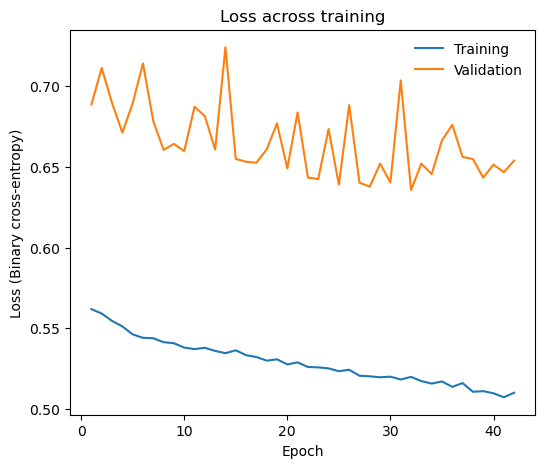

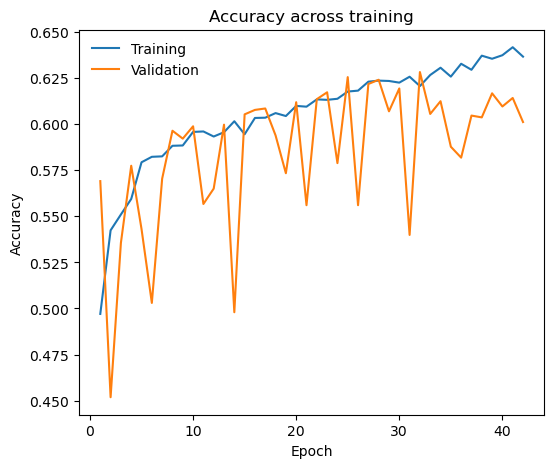

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False)

plt.show()

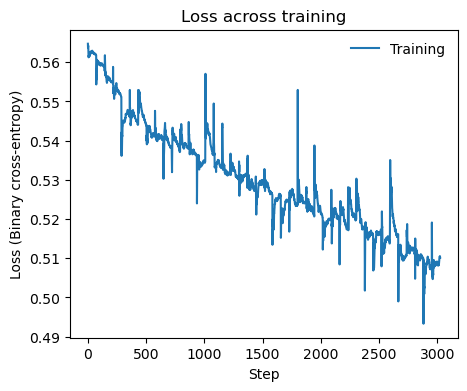

In [22]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(loss_history.losses) + 1)
y_train = loss_history.losses
# y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
# ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
# ax.set_xlim(1000, 3000)
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.show()

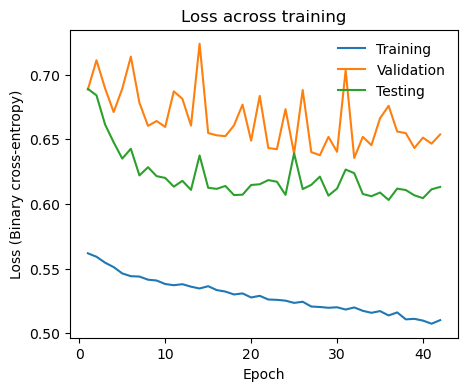

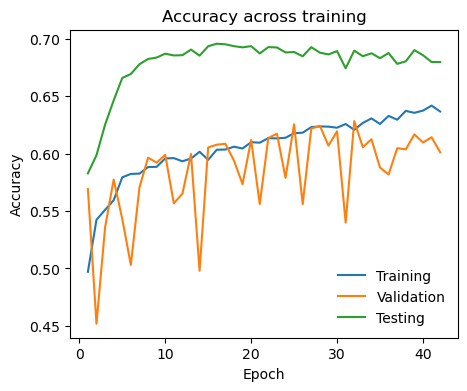

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']
y_testing = testing_callback.testing_loss

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')
ax.plot(x, y_testing, label='Testing')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False,)

# plt.savefig('../figures/HVmodel_loss_curve_copy_1_SB_3_res_75_split_val.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']
y_testing = testing_callback.testing_accuracy

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')
ax.plot(x, y_testing, label='Testing')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False,)

# plt.savefig('../figures/HVmodel_acc_curve_copy_1_SB_3_res_75_split_val.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Training results

## Model

In [24]:
save_model_name = f'CNN_models/last_model_CNN/'

loaded_model = tf.keras.models.load_model(save_model_name)

## Testing data

In [25]:
# sample_dir = f'../Sample/HVmodel/data/split_val/25x25/mix_sample_test.npy'
# X_test, y_test = utils.load_samples(sample_dir)

results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

625/625 [==============================] - 3s 5ms/step - loss: 0.6239 - accuracy: 0.6625
Testing Loss = 0.624, Testing Accuracy = 0.663


625/625 [==============================] - 3s 5ms/step


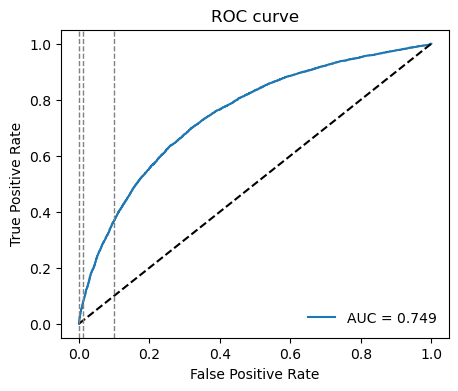

In [26]:
# Plot ROC curve
y_pred = loaded_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
ax.plot([0, 1], [0, 1], 'k--')

ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(frameon=False)

plt.show()